In [22]:
import numpy as np
import sys
import os
import datasets
from transformers import AutoTokenizer
sys.path.append("..")
from babilong_utils import TaskDataset, SentenceSampler, NoiseInjectionDataset
from babilong_utils import *

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# ### extract dataset archive
# !unzip ../data/tasks_1-20_v1-2.zip -d ../data/

In [3]:
# train_path = "../data/tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_test.txt"

train_path = "../data/tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_train.txt"
test_path = "../data/tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_test.txt"

# train_path = "../data/tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_test.txt"

# train_path = "../data/tasks_1-20_v1-2/en-10k/qa3_three-supporting-facts_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa3_three-supporting-facts_test.txt"

# train_path = "../data/tasks_1-20_v1-2/en-10k/qa5_three-arg-relations_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa5_three-arg-relations_test.txt"

# train_path = "../data/tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_test.txt"

noise_dataset = datasets.load_dataset("pg19")

Using custom data configuration default
Reusing dataset pg19 (/home/jovyan/.cache/huggingface/datasets/pg19/default/0.1.0/64837d6fce7251337df051ca74e9a5435d1c9cb7f3033ba257826e44d338f83c)


### Load task datasets

In [4]:
# task 
max_n_facts = None
task_dataset_train = TaskDataset(train_path, max_n_facts=max_n_facts)
task_dataset_test = TaskDataset(test_path, max_n_facts=max_n_facts)

In [5]:
# fact_lens = [len(dataset_train[i]['facts']) for i in range(1000) ]
# np.unique(fact_lens)

In [6]:
# background text
tokenizer = AutoTokenizer.from_pretrained('gpt2')

noise_sampler_train = SentenceSampler(noise_dataset['train'], tokenizer=tokenizer)
noise_sampler_test = SentenceSampler(noise_dataset['test'], tokenizer=tokenizer)

In [7]:
max_n_segments = 256
segment_size = 512               # max number of tokens in sample
qa_margin = 20
sample_size = max_n_segments * segment_size - qa_margin

dataset_train = NoiseInjectionDataset(task_dataset=task_dataset_train,
                                        noise_sampler=noise_sampler_train,
                                        tokenizer=tokenizer,
                                        sample_size=sample_size)

dataset_test = NoiseInjectionDataset(task_dataset=task_dataset_test,
                                        noise_sampler=noise_sampler_test,
                                        tokenizer=tokenizer,
                                        sample_size=sample_size)

In [8]:
# for n_seg in range(40):
#     sample_size = (512 - 1) * n_seg
#     print(n_seg, sample_size % 512)


In [9]:
sample = dataset_train[0]
sample.keys()

dict_keys(['facts', 'question', 'answer', 'references', 'background_text', 'fact_positions', 'input_tokens', 'question_tokens', 'target_tokens'])

### collate function

In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence

id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
gen_token = tokenizer.encode('GEN')[0]
eos_token = tokenizer.eos_token_id

def collate_fn(batch):
    targets = [torch.tensor(b['target_tokens']) for b in batch]
    input_ids = [torch.tensor(b['input_tokens'] + b['question_tokens'] + [gen_token] + b['target_tokens'] + [eos_token]) for b in batch]
    gen_inputs = [torch.tensor(b['input_tokens'] + b['question_tokens'] + [gen_token]) for b in batch]

    attention_mask = [torch.ones_like(b, dtype=int) for b in input_ids]
    labels_mask = [torch.zeros_like(b, dtype=bool) for b in input_ids]
    for m, t in zip(labels_mask, targets):
        m[-len(t) - 2:] = True

    input_ids = pad_sequence(input_ids, padding_value=id_pad_value, batch_first=True)
    gen_inputs = pad_sequence(gen_inputs, padding_value=id_pad_value, batch_first=True)
    attention_mask = pad_sequence(attention_mask, padding_value=0, batch_first=True)
    labels_mask = pad_sequence(labels_mask, padding_value=0, batch_first=True)

    collated = {}
    collated['input_ids'] = collated['labels'] = input_ids
    collated['input_ids_generate'] = gen_inputs
    collated['labels_mask'] = labels_mask
    collated['attention_mask'] = attention_mask.bool()
    collated['attention_mask_generate'] = (gen_inputs != id_pad_value).bool()
    collated['target_text'] = [b['answer'] for b in batch]
    return collated

In [11]:
ids = [0]
batch = [dataset_train[i] for i in ids]
collated = collate_fn(batch)
collated.keys()

dict_keys(['input_ids', 'labels', 'input_ids_generate', 'labels_mask', 'attention_mask', 'attention_mask_generate', 'target_text'])

In [12]:
sample = dataset_train[ids[0]]

In [13]:
facts = sample['facts']
tokens = collated['input_ids'][0]
text = tokenizer.decode(tokens)

In [14]:
def find_fact(fact, tokens):
    text = tokenizer.decode(tokens)
    if fact not in text:
        return None
    fact_pos = len(tokenizer.encode(text[:text.index(fact)]))
    return fact_pos

def get_fact_positions(facts, tokens):
    fact_positions = []
    current_ind = 0
    for f in facts:
        pos = find_fact(f, tokens[current_ind:])
        offset = pos + len(tokenizer.encode(f))
        fact_positions.append(current_ind + pos)
        current_ind += offset

    return fact_positions

In [15]:
fact_positions = get_fact_positions(facts, tokens)
fact_positions

Token indices sequence length is longer than the specified maximum sequence length for this model (54372 > 1024). Running this sequence through the model will result in indexing errors


[54372, 84896]

In [16]:
fact_segments = [f // segment_size for f in fact_positions]
important_segments = np.unique(fact_segments)
important_segments

array([106, 165])

### test a model

In [17]:
from transformers import AutoModelForCausalLM
from modeling_rmt.language_modeling import MemoryCell, RecurrentWrapper
from modeling_rmt.experimental import MemoryCellGenerate

In [31]:
num_mem_tokens = 16
model = AutoModelForCausalLM.from_pretrained('gpt2')
cell = MemoryCellGenerate(model, num_mem_tokens=num_mem_tokens)
model = RecurrentWrapper(cell, 
                        segment_size=512,
                        max_n_segments=max_n_segments, 
                        segment_alignment=None,
                        k2=-1,
)
                            

## load cpt of rmt
# cpt_path = "/home/jovyan/rmt/runs/babilong/qa1_single-supporting-fact/gpt2/linear_adamw_wd1e-03_64x512_mem16_bs64_bptt--1_from_cpt_32-64/run_4/model_best/pytorch_model.bin"
cpt_path = "/home/jovyan/rmt/runs/babilong/qa1_single-supporting-fact/gpt2/linear_adamw_wd1e-03_32x512_mem16_bs64_bptt--1_from_cpt_16-32/run_5/model_best/pytorch_model.bin"
# cpt_path = "/home/jovyan/rmt/runs/babilong/qa5_three-arg-relations/gpt2/linear_adamw_wd1e-03_1x512_mem16_bs64_bptt--1_from_cpt_0-1/run_4/model_best/pytorch_model.bin"
cpt = torch.load(cpt_path, map_location='cpu')
model.load_state_dict(cpt, strict=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[2024-02-01 12:02:30,010] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


<All keys matched successfully>

In [287]:
# input_ids_generate = collated.pop('input_ids_generate')
# attention_mask_generate = collated.pop('attention_mask_generate')
# target_text = collated.pop('target_text')

In [288]:
# out = model(**collated, output_attentions=True)

In [24]:
import os
save_path = "/home/jovyan/rmt/babilong/data/interpretation"
exp_name = f"qa1_{max_n_segments}seg_cpt_32seg_run5_2"
exp_path = os.path.join(save_path, exp_name)
attn_map_path = os.path.join(save_path, exp_name, 'attn_maps')
memory_state_path = os.path.join(save_path, exp_name, 'memory_states')
token_path = os.path.join(save_path, exp_name, 'segment_tokens')
os.system(f"mkdir {exp_path}; mkdir {attn_map_path}; mkdir {memory_state_path}; mkdir {token_path}")

mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_256seg_cpt_32seg_run5_2’: File exists
mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_256seg_cpt_32seg_run5_2/attn_maps’: File exists
mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_256seg_cpt_32seg_run5_2/memory_states’: File exists
mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_256seg_cpt_32seg_run5_2/segment_tokens’: File exists


256

In [294]:
device = 'cuda:1'
model.to(device)

self = model
input_ids = collated['input_ids']
attention_mask = collated['attention_mask']
labels_mask = collated['labels_mask']
labels = collated['labels']
inputs_embeds = None
output_attentions=True
output_hidden_states=True

memory_state = None
segmented = self.segment(input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask)

cell_outputs = []
# print('\n\n\nForward: ', [s['input_ids'].shape for s in segmented])
for seg_num, segment in enumerate(segmented):
    with torch.no_grad():
        for k in segment:
            segment[k] = segment[k].to(device)
        cell_out, memory_state = self.memory_cell(**segment, memory_state=memory_state, output_hidden_states=True, output_attentions=True)
    attentions = torch.stack(cell_out.attentions)
    torch.save(memory_state, os.path.join(memory_state_path, f"seg_{seg_num}"))

    if seg_num in important_segments:
        torch.save(attentions[-1, 0], os.path.join(attn_map_path, f"seg_{seg_num}"))
        torch.save(segment['input_ids'][0], os.path.join(token_path, f"seg_{seg_num}"))

torch.save(attentions[-1, 0], os.path.join(attn_map_path, f"seg_{seg_num}"))
torch.save(segment['input_ids'][0], os.path.join(token_path, f"seg_{seg_num}"))

    
    
    # cell_outputs.append(cell_out)
    # memory_state = self.manage_gradients(memory_state, seg_num)

# out = self.process_outputs(cell_outputs, labels=labels, 
#                             labels_mask=labels_mask,
#                             output_attentions=output_attentions, 
#                             output_hidden_states=output_hidden_states)

### plot attention maps

In [25]:
# ticks = list(range(attn_map.shape[1]))
# ticklabels = ['' for _ in range(len(ticks))]
# for (start, end) in fact_positions:
#     for i in range(start, end):
#         ticklabels[i] = 'f'
# ticks = [list(range(start, end)) for (start, end) in fact_positions]
# ticks = [t for ts in ticks for t in ts]
# ticks = [t + num_mem_tokens for t in ticks]
# ticklabels = ['f' for _ in range(len(ticks))]

In [26]:
# head_map.shape

In [27]:
# xticks = [t - x_min for t in ticks if (t >= x_min and t < x_max)]
# yticks = [t - y_min for t in ticks if (t >= y_min and t < y_max)]
# yticks

### save fact to memory

In [28]:
for seg_num in important_segments:
    attn_path = os.path.join(attn_map_path, f"seg_{seg_num}")
    tok_path = os.path.join(token_path, f"seg_{seg_num}")

    attn_map = torch.load(attn_path)
    tok = torch.load(tok_path)
    break


In [29]:
fact_positions = [(find_fact(f, tok), find_fact(f, tok) + len(tokenizer.encode(f))) for f in facts if find_fact(f, tok) is not None]
# fact_positions

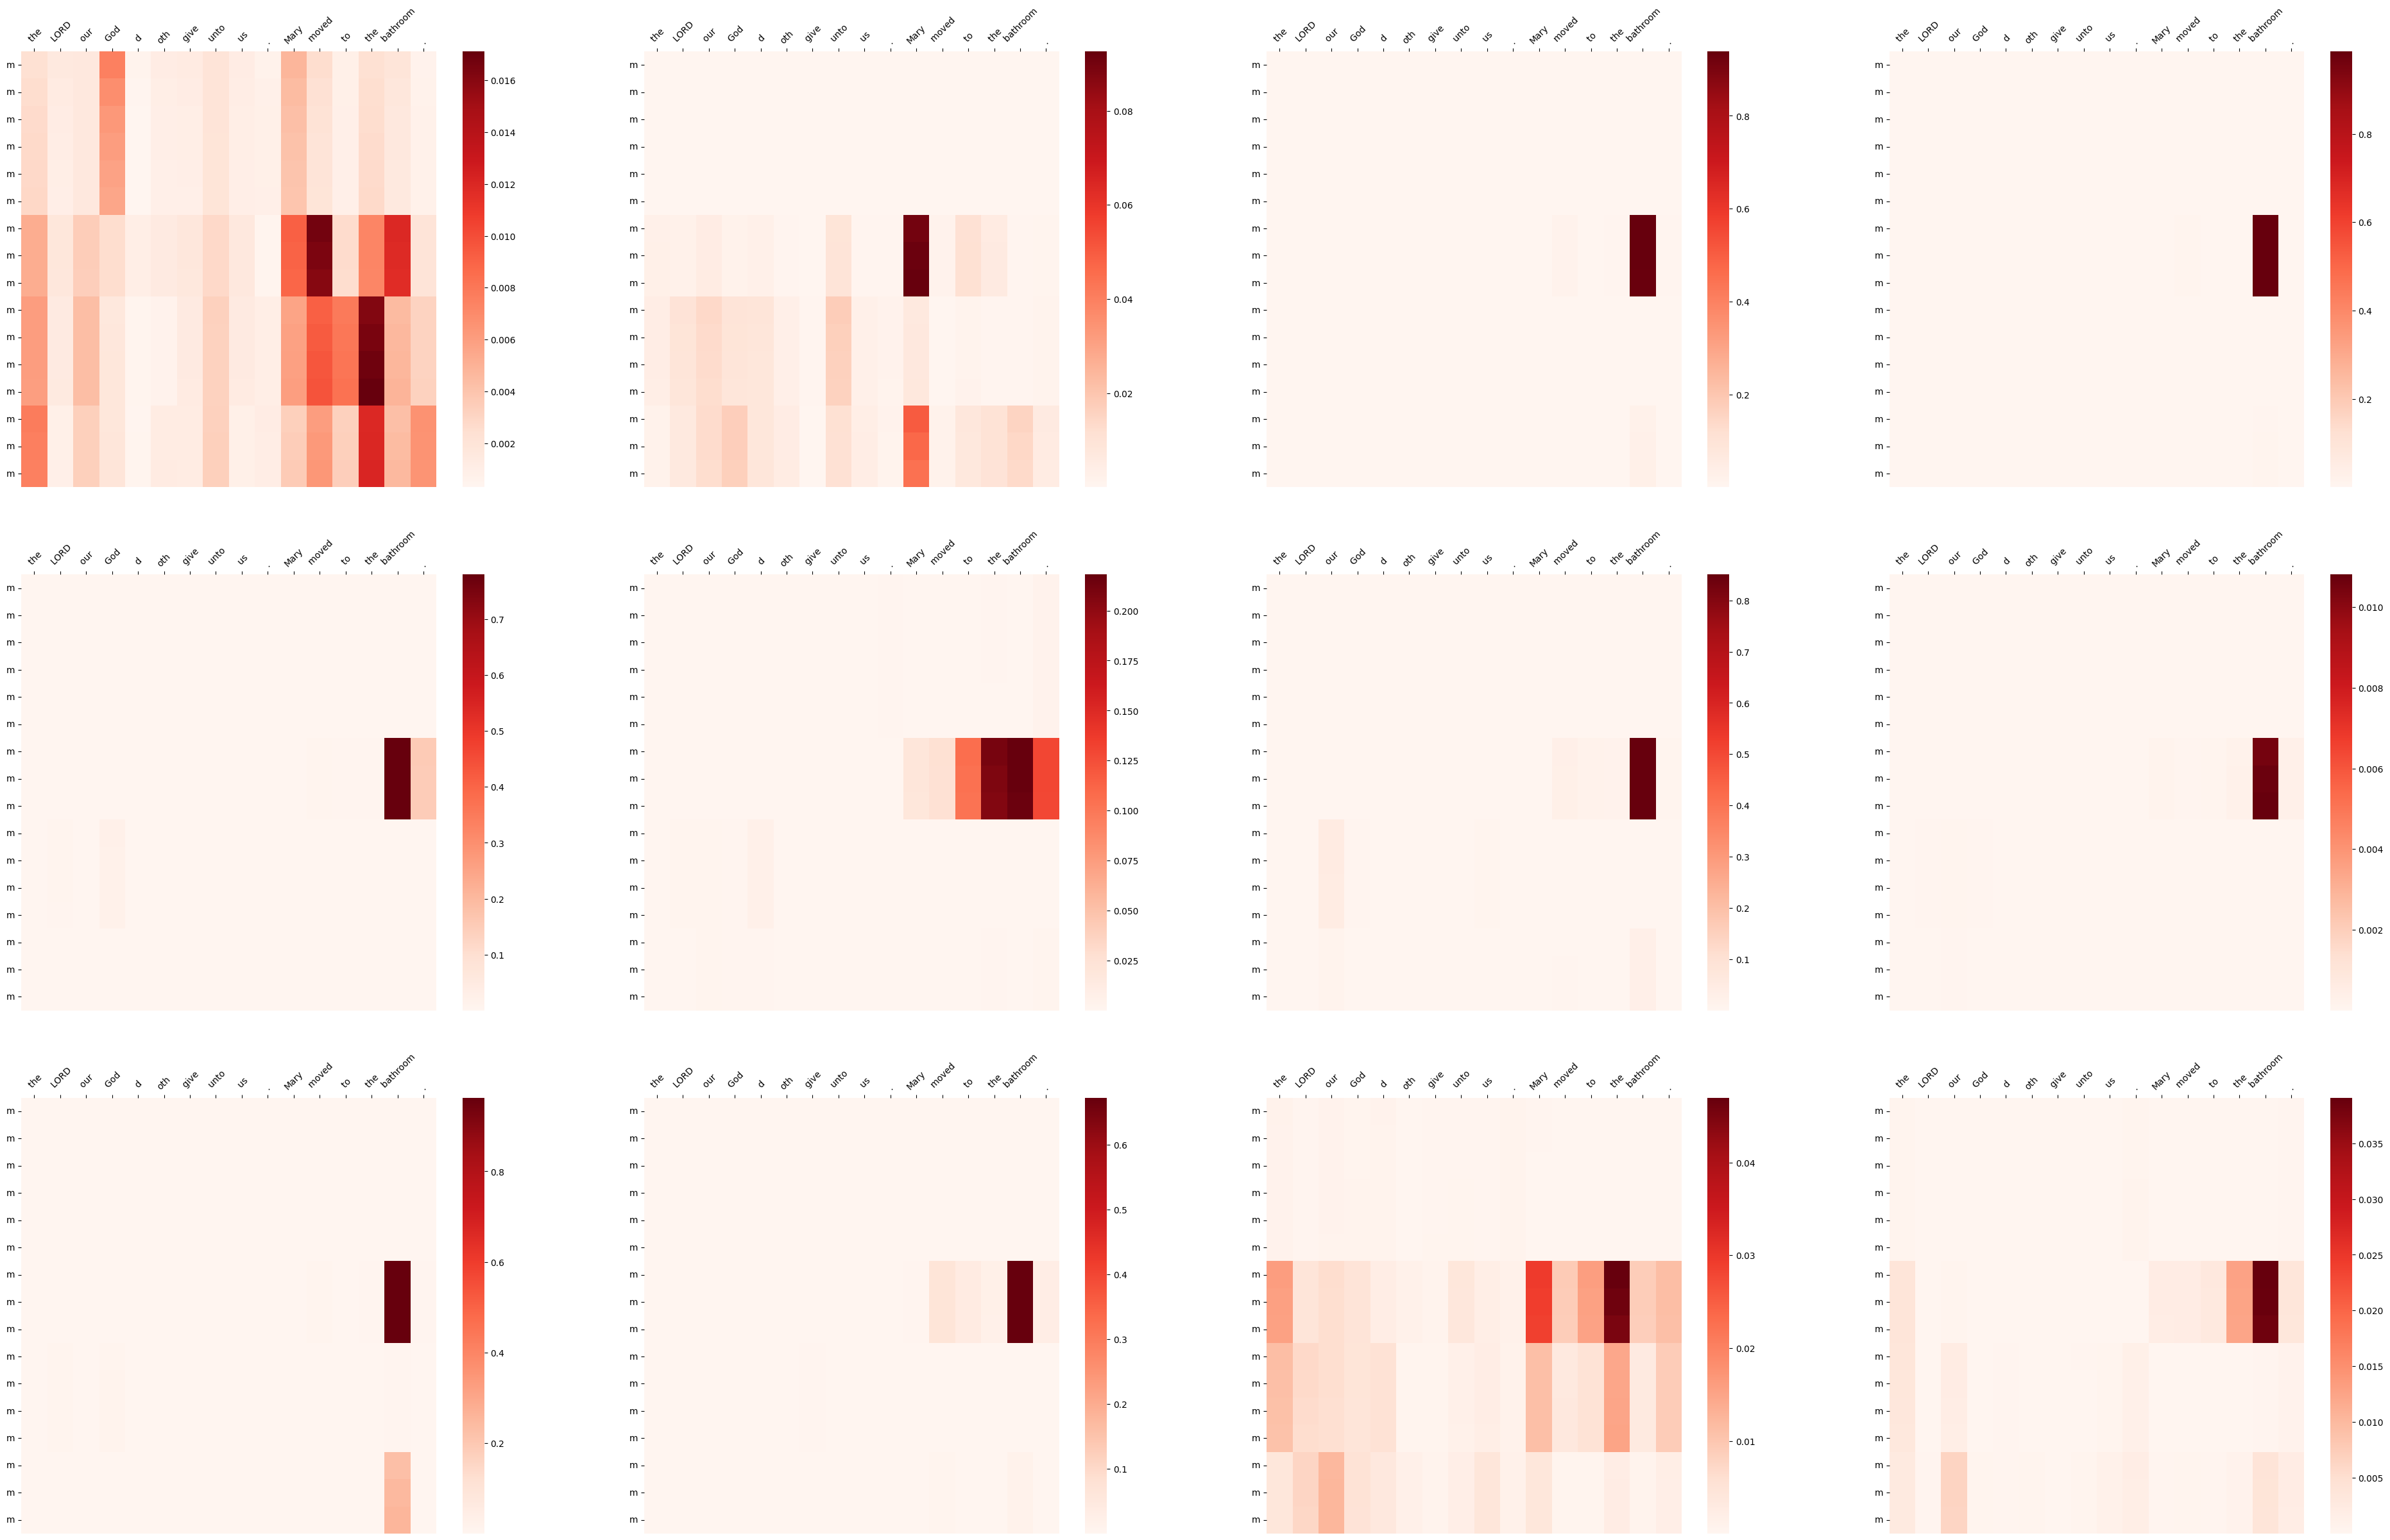

In [32]:
size = 10
nrows, ncols = 3, 4
seg_tokens = ['m']* num_mem_tokens + [tokenizer.decode(t) for t in tok]  + ['m'] * num_mem_tokens
fix, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * size * 1.2, nrows * size))

for map_ind in range(attn_map.shape[0]):
    row = map_ind // nrows
    col = map_ind % nrows
    head_map = attn_map[map_ind].cpu().numpy()

    ax = axs[col, row]


    x_min, x_max = fact_positions[0]
    x_min -= 10
    x_max += 0
    y_min, y_max = 512, 545

    x_min += num_mem_tokens
    y_min += num_mem_tokens
    x_max += num_mem_tokens
    y_max += num_mem_tokens

    # plt.figure(figsize=((y_max - y_min) // 2, (x_max - x_min) // 2))


    map = head_map[y_min:y_max , x_min:x_max]

    ax = sns.heatmap(map, cmap='Reds', ax=ax)

    ticks = range(len(seg_tokens))
    ticklabels = seg_tokens

    xticks = [t - x_min + 0.5 for t in ticks if (t >= x_min and t < x_max)]
    yticks = [t - y_min + 0.5 for t in ticks if (t >= y_min and t < y_max)]

    xticklabels = ticklabels[x_min: x_max]
    yticklabels = ticklabels[y_min: y_max]

    # plt.xticks(xticks, labels=xticklabels)
    # plt.yticks(yticks, labels=yticklabels)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_yticklabels(yticklabels, rotation=0)
    ax.xaxis.tick_top()

plt.savefig(f'figures/{exp_name}_attn_save_1.pdf', format='pdf')
plt.savefig(f'figures/{exp_name}_attn_save_1.png', format='png')
plt.show()

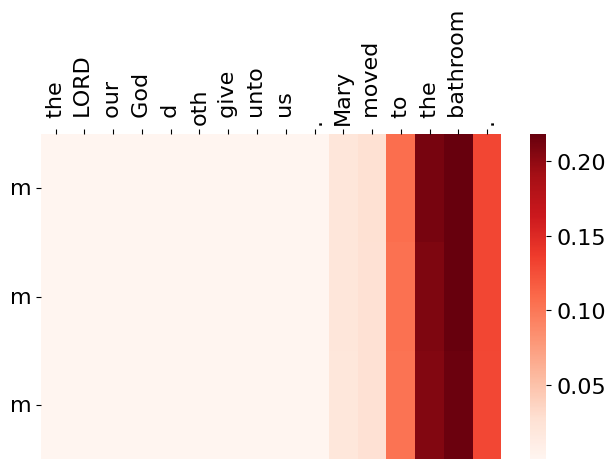

In [41]:
map_ind = 4
seg_tokens = ['m']* num_mem_tokens + [tokenizer.decode(t) for t in tok]  + ['m'] * num_mem_tokens

ow = map_ind // nrows
col = map_ind % nrows
head_map = attn_map[map_ind].cpu().numpy()

ax = axs[col, row]


x_min, x_max = fact_positions[0]
x_min -= 10
x_max += 0
y_min, y_max = 518, 521

x_min += num_mem_tokens
y_min += num_mem_tokens
x_max += num_mem_tokens
y_max += num_mem_tokens

# plt.figure(figsize=((y_max - y_min) // 2, (x_max - x_min) // 2))


map = head_map[y_min:y_max , x_min:x_max]

ax = sns.heatmap(map, cmap='Reds')#, annot=True, annot_kws={"size": 10})

ticks = range(len(seg_tokens))
ticklabels = seg_tokens

xticks = [t - x_min + 0.5 for t in ticks if (t >= x_min and t < x_max)]
yticks = [t - y_min + 0.5 for t in ticks if (t >= y_min and t < y_max)]

xticklabels = ticklabels[x_min: x_max]
yticklabels = ticklabels[y_min: y_max]

# plt.xticks(xticks, labels=xticklabels)
# plt.yticks(yticks, labels=yticklabels)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xticklabels, rotation=90, fontsize=16)
ax.set_yticklabels(yticklabels, rotation=0, fontsize=16)
ax.xaxis.tick_top()

# ax.set_xlabel('(c)', fontsize=20)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig(f'figures/attn_write_to_mem.pdf', format='pdf')
plt.savefig(f'figures/attn_write_to_mem.png', format='png')
plt.show()

### read fact from memory

In [42]:
attn_path = os.path.join(attn_map_path, f"seg_255")
tok_path = os.path.join(token_path, f"seg_255")

attn_map = torch.load(attn_path)
tok = torch.load(tok_path)

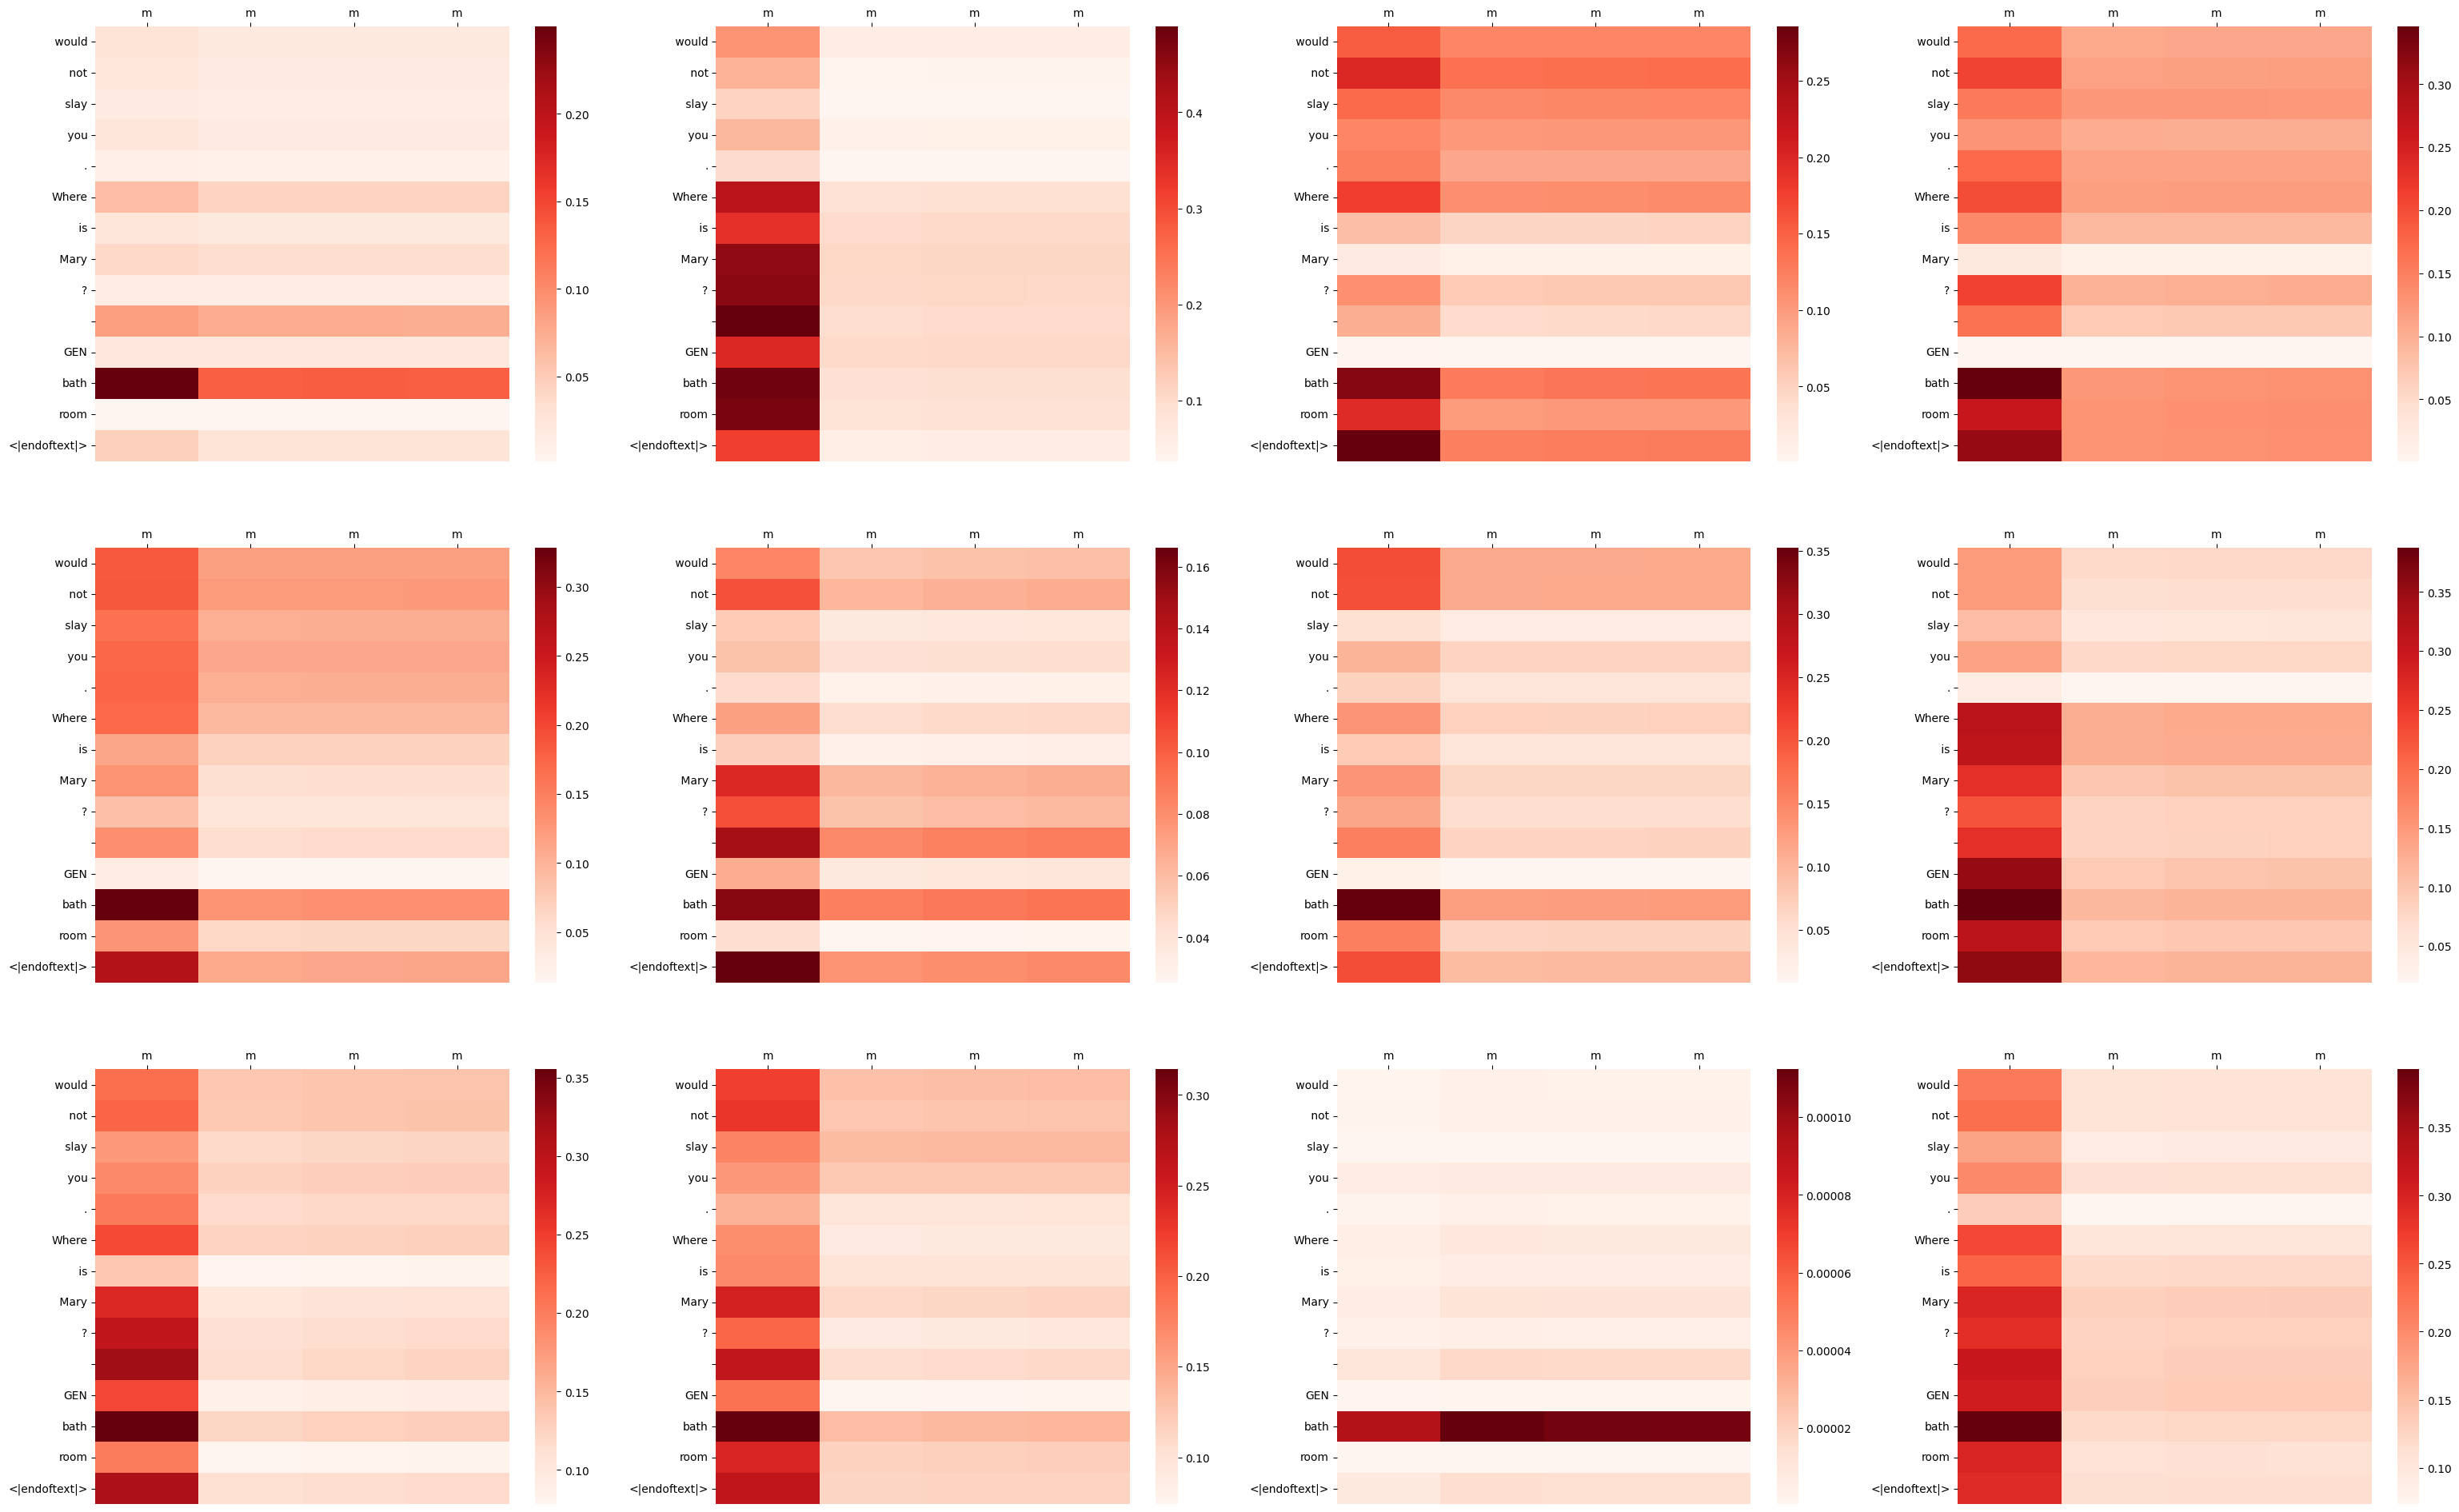

In [43]:
size = 8
nrows, ncols = 3, 4
seg_tokens = ['m']* num_mem_tokens + [tokenizer.decode(t) for t in tok]  + ['m'] * num_mem_tokens
fix, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * size * 1.2, nrows * size))

for map_ind in range(attn_map.shape[0]):
    row = map_ind // nrows
    col = map_ind % nrows
    head_map = attn_map[map_ind].cpu().numpy()

    ax = axs[col, row]


    # x_min -= 10
    # x_max += 0
    x_min, x_max = 0, 4
    y_min, y_max = 487, 501

    # x_min += num_mem_tokens
    y_min += num_mem_tokens
    # x_max += num_mem_tokens
    y_max += num_mem_tokens

    # plt.figure(figsize=((y_max - y_min) // 2, (x_max - x_min) // 2))


    map = head_map[y_min:y_max , x_min:x_max]

    ax = sns.heatmap(map, cmap='Reds', ax=ax)

    ticks = range(len(seg_tokens))
    ticklabels = seg_tokens

    xticks = [t - x_min + 0.5 for t in ticks if (t >= x_min and t < x_max)]
    yticks = [t - y_min + 0.5 for t in ticks if (t >= y_min and t < y_max)]

    xticklabels = ticklabels[x_min: x_max]
    yticklabels = ticklabels[y_min: y_max]

    # plt.xticks(xticks, labels=xticklabels)
    # plt.yticks(yticks, labels=yticklabels)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_yticklabels(yticklabels, rotation=0)
    ax.xaxis.tick_top()

plt.savefig(f'figures/{exp_name}_attn_load.pdf', format='pdf')
plt.savefig(f'figures/{exp_name}_attn_load.png', format='png')
plt.show()

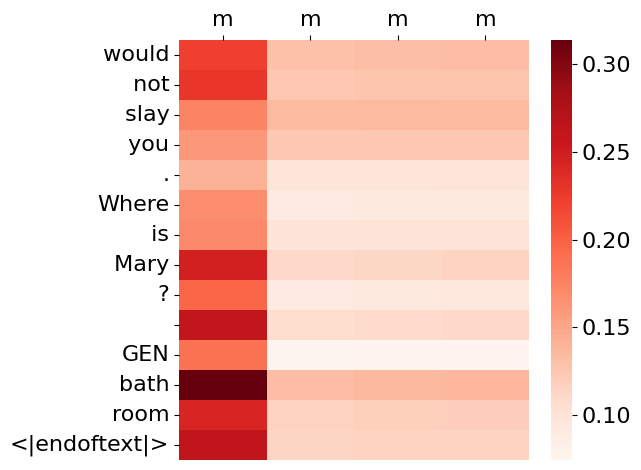

In [44]:
row = map_ind // nrows
col = map_ind % nrows
map_ind = 5
head_map = attn_map[map_ind].cpu().numpy()


# x_min -= 10
# x_max += 0
x_min, x_max = 0, 4
y_min, y_max = 487, 501

# x_min += num_mem_tokens
y_min += num_mem_tokens
# x_max += num_mem_tokens
y_max += num_mem_tokens

# plt.figure(figsize=((y_max - y_min) // 2, (x_max - x_min) // 2))


map = head_map[y_min:y_max , x_min:x_max]

ax = sns.heatmap(map, cmap='Reds')

ticks = range(len(seg_tokens))
ticklabels = seg_tokens

xticks = [t - x_min + 0.5 for t in ticks if (t >= x_min and t < x_max)]
yticks = [t - y_min + 0.5 for t in ticks if (t >= y_min and t < y_max)]

xticklabels = ticklabels[x_min: x_max]
yticklabels = ticklabels[y_min: y_max]

# plt.xticks(xticks, labels=xticklabels)
# plt.yticks(yticks, labels=yticklabels)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xticklabels, rotation=0, fontsize=16)
ax.set_yticklabels(yticklabels, rotation=0, fontsize=16)
ax.xaxis.tick_top()


# ax.set_xlabel('(d)', fontsize=20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()

plt.savefig(f'figures/attn_read_from_mem.pdf', format='pdf')
plt.savefig(f'figures/attn_read_from_mem.png', format='png')
plt.show()

In [160]:
# seg_tokens = ['m']* num_mem_tokens + [tokenizer.decode(t) for t in tok]  + ['m'] * num_mem_tokens

# x_min, x_max = fact_positions[0]
# x_min -= 10
# x_max += 0
# y_min, y_max = 512, 545

# x_min += num_mem_tokens
# y_min += num_mem_tokens
# x_max += num_mem_tokens
# y_max += num_mem_tokens

# plt.figure(figsize=((y_max - y_min) // 2, (x_max - x_min) // 2))


# map_ind = 3
# head_map = attn_map[map_ind].cpu().numpy()
# map = head_map[y_min:y_max , x_min:x_max]

# ax = sns.heatmap(map, cmap='Reds', ax=ax)

# ticks = range(len(seg_tokens))
# ticklabels = seg_tokens

# xticks = [t - x_min + 0.5 for t in ticks if (t >= x_min and t < x_max)]
# yticks = [t - y_min + 0.5 for t in ticks if (t >= y_min and t < y_max)]

# xticklabels = ticklabels[x_min: x_max]
# yticklabels = ticklabels[y_min: y_max]

# plt.xticks(xticks, labels=xticklabels)
# plt.yticks(yticks, labels=yticklabels)
# ax.xaxis.tick_top()
# plt.show()

In [57]:
# nrows, ncols = 3, 4

# size = 20
# fix, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * size * 1.2, nrows * size))

# for map_ind in range(attn_map.shape[0]):
#     row = map_ind // nrows
#     col = map_ind % nrows
#     head_map = attn_map[map_ind].cpu().numpy()

#     ax = axs[col, row]
#     sns.heatmap(head_map, cmap='coolwarm_r', ax=ax)

#     break


# # ax = sns.heatmap(map, cmap='coolwarm_r')
# # plt.xticks(ticks, labels=ticklabels)
# # plt.yticks(ticks, labels=ticklabels)
# # ax.xaxis.tick_top()
# # plt.title('Pairwise distances between segment memories')
# # plt.xlabel('segment number')

# # plt.savefig(f'figures/{exp_name}.pdf', format='pdf')
# # plt.savefig(f'figures/{exp_name}.png', format='png')
# plt.show()

### check distance between memory states

In [104]:
max_n_segments = 32
# max_n_segments = 256

In [105]:
import os
save_path = "/home/jovyan/rmt/babilong/data/interpretation"
exp_name = f"qa1_{max_n_segments}seg_cpt_32seg_run5_2"
exp_path = os.path.join(save_path, exp_name)
attn_map_path = os.path.join(save_path, exp_name, 'attn_maps')
memory_state_path = os.path.join(save_path, exp_name, 'memory_states')
token_path = os.path.join(save_path, exp_name, 'segment_tokens')
os.system(f"mkdir {exp_path}; mkdir {attn_map_path}; mkdir {memory_state_path}; mkdir {token_path}")

mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_32seg_cpt_32seg_run5_2’: File exists
mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_32seg_cpt_32seg_run5_2/attn_maps’: File exists
mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_32seg_cpt_32seg_run5_2/memory_states’: File exists
mkdir: cannot create directory ‘/home/jovyan/rmt/babilong/data/interpretation/qa1_32seg_cpt_32seg_run5_2/segment_tokens’: File exists


256

In [106]:
seg_path = os.path.join(memory_state_path, f"seg_{max_n_segments - 1}")
last_memory_state = torch.load(seg_path)
last_memory_state_flat = last_memory_state.view(-1)

In [107]:
distances = []
flat_memory_states = []
for seg_num in range(max_n_segments):
    seg_path = os.path.join(memory_state_path, f"seg_{seg_num}")
    memory_state = torch.load(seg_path)
    memory_state_flat = memory_state.view(-1)
    flat_memory_states.append(memory_state_flat)
    dist = torch.dist(memory_state_flat, last_memory_state_flat).item()
    distances.append(dist)

pairwise_distances = torch.cdist(torch.stack(flat_memory_states), torch.stack(flat_memory_states)).cpu().detach().numpy()

In [108]:
# fact_segments = [f // segment_size for f in fact_positions]
# important_segments = np.unique(fact_segments)
important_segments = [12, 18]
# important_segments = [106, 165]
important_segments

[12, 18]

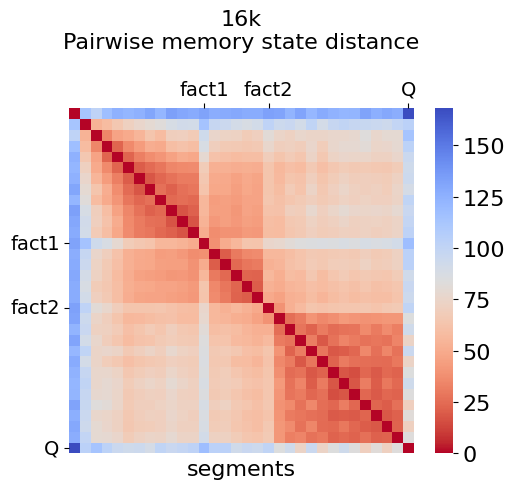

In [110]:
plt.figure(figsize=(5.3, 5 ))
dists = pairwise_distances

ticks = list(important_segments)
ticklabels = [f'fact{i}' for i in range(1, len(ticks)+1)] + ['Q']
ticks = np.array(ticks + [dists.shape[0]-1]) + 0.5


ax = sns.heatmap(dists, cmap='coolwarm_r')
plt.xticks(ticks, labels=ticklabels, fontsize=14, rotation=0)
plt.yticks(ticks, labels=ticklabels, fontsize=14, rotation=0)
ax.xaxis.tick_top()
plt.title('16k\nPairwise memory state distance\n', fontsize=16)
plt.xlabel('segments', fontsize=16)
# plt.xlabel('segments\n(a)', fontsize=20)

# plt.savefig(f'figures/{exp_name}.pdf', format='pdf')
# plt.savefig(f'figures/{exp_name}.png', format='png')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)


plt.tight_layout()
plt.savefig(f'figures/rmt_mem_pairwise_similarity_short.pdf', format='pdf')
plt.savefig(f'figures/rmt_mem_pairwise_similarity_short.png', format='png')
plt.show()

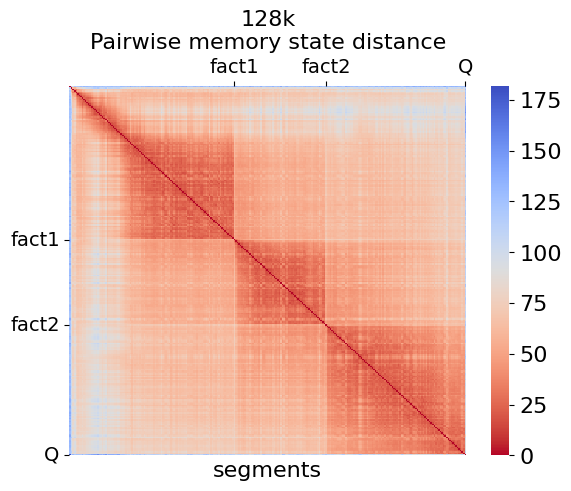

In [103]:
# plt.figure(figsize=(5, 5 ))
dists = pairwise_distances

ticks = list(important_segments)
ticklabels = [f'fact{i}' for i in range(1, len(ticks)+1)] + ['Q']
ticks = np.array(ticks + [dists.shape[0]-1]) + 0.5


ax = sns.heatmap(dists, cmap='coolwarm_r')
plt.xticks(ticks, labels=ticklabels, fontsize=14)
plt.yticks(ticks, labels=ticklabels, fontsize=14)
ax.xaxis.tick_top()
plt.title('128k\nPairwise memory state distance', fontsize=16)
# plt.xlabel('segments\n(b)', fontsize=20)
plt.xlabel('segments', fontsize=16)

# plt.savefig(f'figures/{exp_name}.pdf', format='pdf')
# plt.savefig(f'figures/{exp_name}.png', format='png')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

# plt.tight_layout()
plt.savefig(f'figures/rmt_mem_pairwise_similarity.pdf', format='pdf')
plt.savefig(f'figures/rmt_mem_pairwise_similarity.png', format='png')
plt.show()

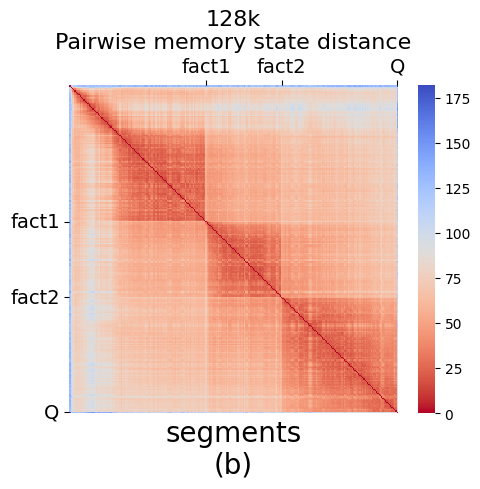

In [ ]:
plt.figure(figsize=(5, 5 ))
dists = pairwise_distances

ticks = list(important_segments)
ticklabels = [f'fact{i}' for i in range(1, len(ticks)+1)] + ['Q']
ticks = np.array(ticks + [dists.shape[0]-1]) + 0.5


ax = sns.heatmap(dists, cmap='coolwarm_r')
plt.xticks(ticks, labels=ticklabels, fontsize=14)
plt.yticks(ticks, labels=ticklabels, fontsize=14)
ax.xaxis.tick_top()
plt.title('128k\nPairwise memory state distance', fontsize=16)
plt.xlabel('segments\n(b)', fontsize=20)

# plt.savefig(f'figures/{exp_name}.pdf', format='pdf')
# plt.savefig(f'figures/{exp_name}.png', format='png')
plt.tight_layout()
plt.savefig(f'figures/rmt_mem_pairwise_similarity.pdf', format='pdf')
plt.savefig(f'figures/rmt_mem_pairwise_similarity.png', format='png')
plt.show()

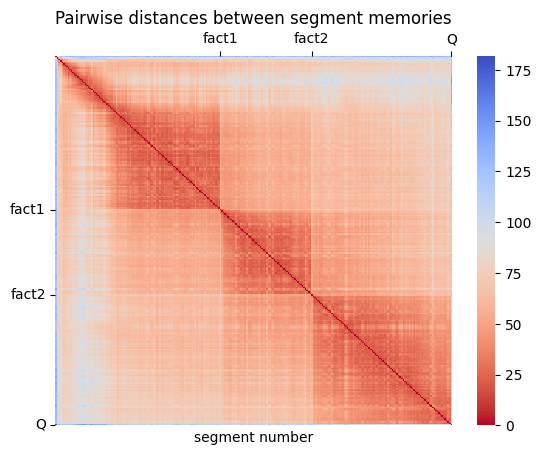

In [ ]:
dists = pairwise_distances

ticks = list(important_segments)
ticklabels = [f'fact{i}' for i in range(1, len(ticks)+1)] + ['Q']
ticks = np.array(ticks + [dists.shape[0]-1]) + 0.5


ax = sns.heatmap(dists, cmap='coolwarm_r')
plt.xticks(ticks, labels=ticklabels)
plt.yticks(ticks, labels=ticklabels)
ax.xaxis.tick_top()
plt.title('Pairwise distances between segment memories')
plt.xlabel('segment number')

plt.savefig(f'figures/{exp_name}.pdf', format='pdf')
plt.savefig(f'figures/{exp_name}.png', format='png')
plt.show()

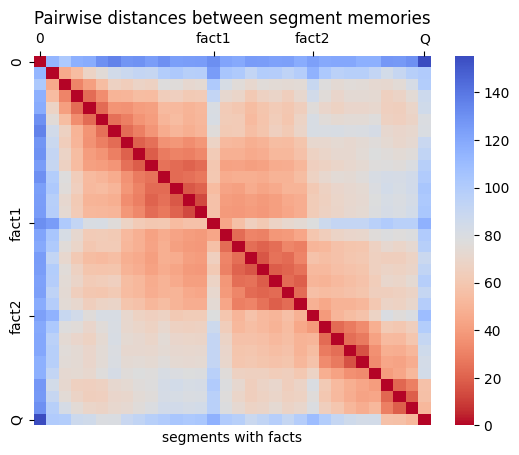

In [ ]:
dists = pairwise_distances

ticks = list(important_segments)
ticklabels = ['0'] + [f'fact{i}' for i in range(1, len(ticks)+1)] + ['Q']
ticks = np.array([0] + ticks + [dists.shape[0]-1]) + 0.5


ax = sns.heatmap(dists, cmap='coolwarm_r')
plt.xticks(ticks, labels=ticklabels)
plt.yticks(ticks, labels=ticklabels)
ax.xaxis.tick_top()
plt.title('Pairwise distances between segment memories')
plt.xlabel('segments with facts')
plt.show()


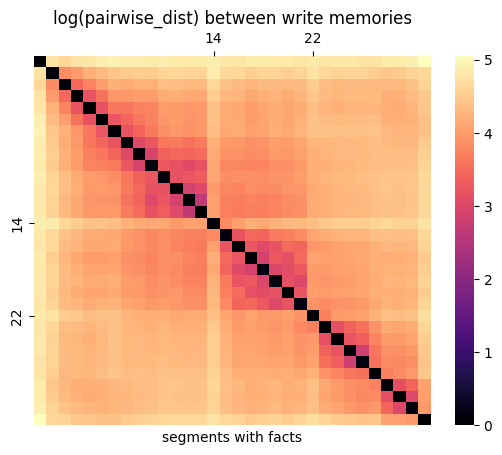

In [ ]:
dists = np.log(pairwise_distances + 1)
# for i in range(dists.shape[0]):
#     dists[i, i] = 0

ax = sns.heatmap(dists, cmap='magma')
plt.xticks(important_segments + 0.5, labels=important_segments)
plt.yticks(important_segments + 0.5, labels=important_segments)
ax.xaxis.tick_top()
plt.title('log(pairwise_dist) between write memories')
plt.xlabel('segments with facts')
plt.show()

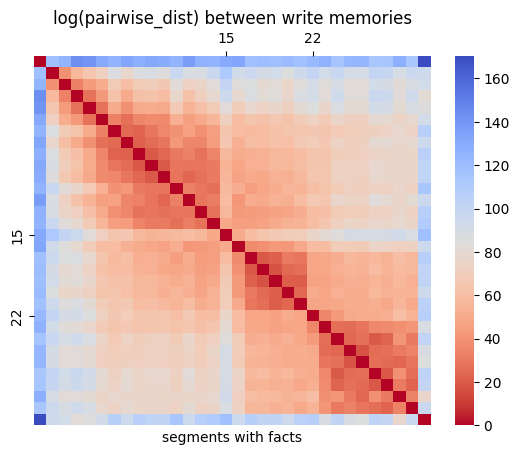

In [ ]:
dists = pairwise_distances
# for i in range(dists.shape[0]):
#     dists[i, i] = 0

ax = sns.heatmap(dists, cmap='coolwarm_r')
plt.xticks(important_segments + 0.5, labels=important_segments)
plt.yticks(important_segments + 0.5, labels=important_segments)
ax.xaxis.tick_top()
plt.title('log(pairwise_dist) between write memories')
plt.xlabel('segments with facts')
plt.show()

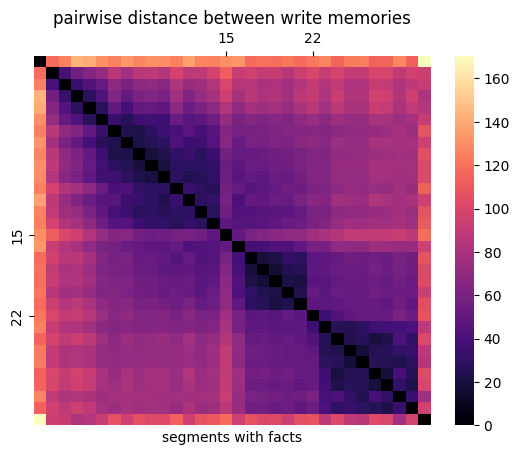

In [ ]:
dists = pairwise_distances
# for i in range(dists.shape[0]):
#     dists[i, i] = 0

ax = sns.heatmap(dists, cmap='magma')
plt.xticks(important_segments + 0.5, labels=important_segments)
plt.yticks(important_segments + 0.5, labels=important_segments)
ax.xaxis.tick_top()
plt.title('pairwise distance between write memories')
plt.xlabel('segments with facts')
plt.show()

/tmp/ipykernel_866452/1856509956.py:1: RuntimeWarning: divide by zero encountered in log
  dists = np.log(pairwise_distances)


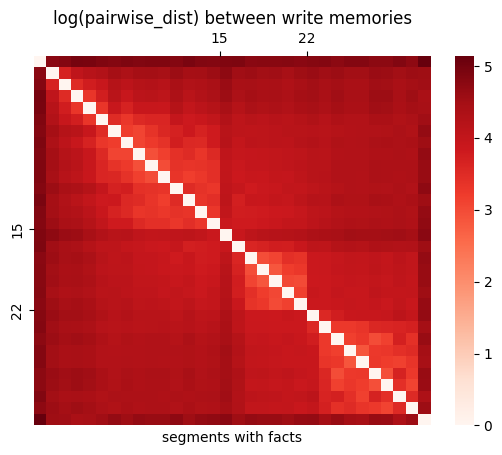

In [ ]:
dists = np.log(pairwise_distances)
for i in range(dists.shape[0]):
    dists[i, i] = 0
    
ax = sns.heatmap(dists, cmap='Reds')
plt.xticks(important_segments, labels=important_segments)
plt.yticks(important_segments, labels=important_segments)
ax.xaxis.tick_top()
plt.title('log(pairwise_dist) between write memories')
plt.xlabel('segments with facts')
plt.show()

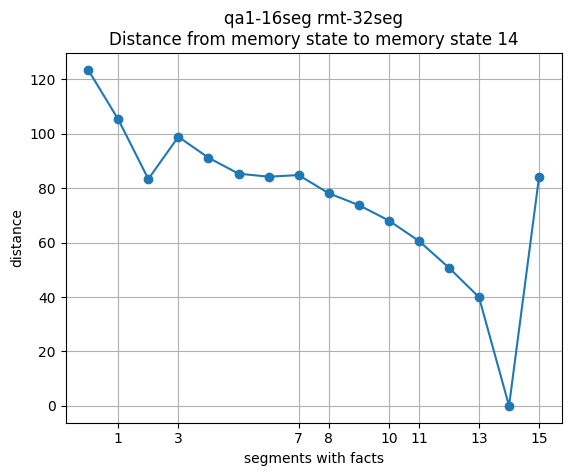

In [ ]:
plt.plot(distances, marker='o')

plt.xlabel('segments with facts')
plt.ylabel('distance')
plt.title('qa1-16seg rmt-32seg\nDistance from memory state to memory state')
plt.xticks(important_segments)
plt.grid(True)
plt.show()

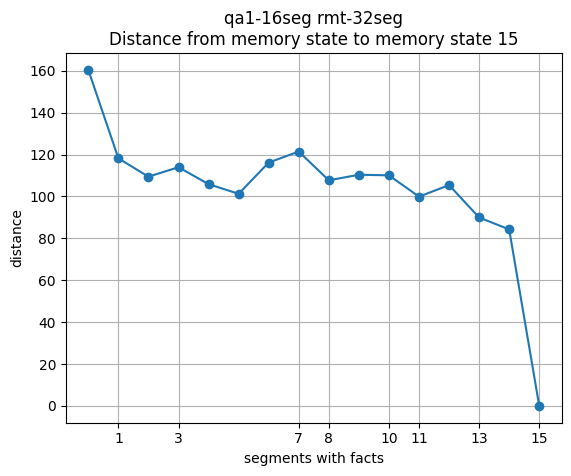

In [ ]:
plt.plot(distances, marker='o')

plt.xlabel('segments with facts')
plt.ylabel('distance')
plt.title('qa1-16seg rmt-32seg\nDistance from memory state to memory state 15')
plt.xticks(important_segments)
plt.grid(True)
plt.show()

In [ ]:
facts

array(['Daniel journeyed to the hallway.', 'Mary went to the office.',
       'Mary moved to the kitchen.', 'Mary went to the office.',
       'Sandra journeyed to the hallway.', 'Mary moved to the kitchen.',
       'Mary moved to the office.', 'Daniel journeyed to the garden.',
       'Daniel moved to the office.', 'John journeyed to the office.'],
      dtype=object)

In [ ]:
out.keys()

odict_keys(['loss', 'logits', 'hidden_states', 'logits_0', 'hidden_states_0', 'logits_1', 'hidden_states_1', 'logits_2', 'hidden_states_2', 'logits_3', 'hidden_states_3', 'logits_4', 'hidden_states_4', 'logits_5', 'hidden_states_5', 'logits_6', 'hidden_states_6', 'logits_7', 'hidden_states_7', 'logits_8', 'hidden_states_8', 'logits_9', 'hidden_states_9', 'logits_10', 'hidden_states_10', 'logits_11', 'hidden_states_11', 'logits_12', 'hidden_states_12', 'logits_13', 'hidden_states_13', 'logits_14', 'hidden_states_14', 'logits_15', 'hidden_states_15', 'logits_16', 'hidden_states_16', 'logits_17', 'hidden_states_17', 'logits_18', 'hidden_states_18', 'logits_19', 'hidden_states_19', 'logits_20', 'hidden_states_20', 'logits_21', 'hidden_states_21', 'logits_22', 'hidden_states_22', 'logits_23', 'hidden_states_23', 'logits_24', 'hidden_states_24', 'logits_25', 'hidden_states_25', 'logits_26', 'hidden_states_26', 'logits_27', 'hidden_states_27', 'logits_28', 'hidden_states_28', 'logits_29', 'hi

In [ ]:
generated = model.generate(input_ids_generate, attention_mask=attention_mask_generate, max_new_tokens=10, pad_token_id=id_pad_value)

In [ ]:
target_text

['football',
 'Bill',
 'Bill',
 'Bill',
 'Jeff',
 'Jeff',
 'Jeff',
 'Mary',
 'Bill',
 'Bill']

In [ ]:
tokenizer.decode(input_ids[0][attention_mask[0]])

"16:12 And if\nye have not been faithful in that which is another man's, who shall\ngive you that which is your own?16:13 No servant can serve two\nmasters: for either he will hate the one, and love the other; or else\nhe will hold to the one, and despise the other.Ye cannot serve God\nand mammon.Bill travelled to the office.Bill picked up the football there.16:14 And the Pharisees also, who were covetous, heard all these\nthings: and they derided him.Bill went to the bedroom.16:15 And he said unto them, Ye are they which justify yourselves\nbefore men; but God knoweth your hearts: for that which is highly\nesteemed among men is abomination in the sight of God.16:16 The law and the prophets were until John: since that time the\nkingdom of God is preached, and every man presseth into it.16:17 And it is easier for heaven and earth to pass, than one tittle\nof the law to fail.16:18 Whosoever putteth away his wife, and marrieth another,\ncommitteth adultery: and whosoever marrieth her that

In [ ]:
self = model 
input_ids = input_ids_generate[1:2, :-3]
attention_mask = attention_mask_generate[1:2, :-3]
generate_kwargs = {"max_new_tokens":10, "pad_token_id":id_pad_value}


memory_state = None
segmented = self.segment(input_ids=input_ids, attention_mask=attention_mask)

# print('\n\n\nGenerate: ', [s['input_ids'].shape for s in segmented])
for seg_num, segment in enumerate(segmented[:-1]):
    cell_out, memory_state = self.memory_cell(**segment, memory_state=memory_state, output_hidden_states=True)

final_segment = segmented[-1]
out = self.memory_cell.generate(**final_segment, memory_state=memory_state, **generate_kwargs)

In [ ]:
tokenizer.decode(final_segment['input_ids'][0])

"16:26 And beside all this, between us and you there is a great gulf\nfixed: so that they which would pass from hence to you cannot; neither\ncan they pass to us, that would come from thence.Bill travelled to the office.16:27 Then he said, I pray thee therefore, father, that thou wouldest\nsend him to my father's house: 16:28 For I have five brethren; that he\nmay testify unto them, lest they also come into this place of torment.16:29 Abraham saith unto him, They have Moses and the prophets; let\nthem hear them.Bill picked up the football there.16:30 And he said, Nay, father Abraham: but if one went unto them from\nthe dead, they will repent.16:31 And he said unto him, If they hear not Moses and the prophets,\nneither will they be persuaded, though one rose from the dead.17:1 Then said he unto the disciples, It is impossible but that\noffences will come: but woe unto him, through whom they come!17:2 It\nwere better for him that a millstone were hanged about his neck, and\nhe cast into 

In [ ]:
tokenizer.batch_decode(out)

['<|endoftext|>Bill<|endoftext|>']

In [ ]:
segments = torch.split(collated['input_ids_generate'], 512, dim=1)

In [ ]:
[s.shape for s in segments]

[torch.Size([10, 512]), torch.Size([10, 6])]

In [ ]:
segments[-1][6]

tensor([ 6365,    11,   287,   262,   717,  1110,   286,   262,   198, 43556,
         1227,    13,  2091,    25,  2670,   843, 12139,   373,   281,  3470,
          290,  8208,   290,  1115,   812,  1468,   618,   339,   198,    67,
          798,   287,  3817,  6075,    13,  2091,    25,  1821,   843,  5822,
          943,   324,   262, 47047,   578,    11,   543, 43756,  2120,   287,
          262,  5366,   287,   262,   198,  1044,   286, 47047,    11,  2982,
          286,   262,  2406,   286,   262,  1751,   286,  2692,    13,   464,
        14043,   318,  7421,   286,   262, 11376,    13,  2091,    25,  3901,
          843,   484, 24057,   422,  3817,  6075,    11,   290, 21730,   287,
         1168,   282,  2144,   993,    13,  2091,    25,  3682,   843,   484,
        24057,   422,  1168,   282,  2144,   993,    11,   290, 21730,   287,
        14944,   261,    13,  2091,    25,  3559,   843,   484, 24057,   422,
        14944,   261,    11,   290, 21730,   287,  1835,   849, 

In [ ]:
tokenizer.batch_decode(segments[-1])

[' of Israel, two hundred and fifty princes of\nthe assembly, famous in the congregation, men of renown: 16:3 And they\ngathered themselves together against Moses and against Aaron, and said\nunto them, Ye take too much upon you, seeing all the congregation are\nholy, every one of them, and the LORD is among them: wherefore then\nlift ye up yourselves above the congregation of the LORD?16:4 And\nwhen Moses heard it, he fell upon his face: 16:5 And he spake unto\nKorah and unto all his company, saying, Even to morrow the LORD will\nshew who are his, and who is holy; and will cause him to come near\nunto him: even him whom he hath chosen will he cause to come near unto\nhim.16:6 This do; Take you censers, Korah, and all his company; 16:7 And\nput fire therein, and put incense in them before the LORD to morrow:\nand it shall be that the man whom the LORD doth choose, he shall be\nholy: ye take too much upon you, ye sons of Levi.16:8 And Moses said unto Korah, Hear, IWhat is north of the k

In [ ]:
# labels are marked with labels_mask
tokenizer.batch_decode([c[m] for c, m in zip(collated['input_ids'], collated['labels_mask'])])

['GENoffice<|endoftext|>',
 'GENkitchen<|endoftext|>',
 'GENbedroom<|endoftext|>',
 'GENbedroom<|endoftext|>',
 'GENkitchen<|endoftext|>',
 'GENbedroom<|endoftext|>',
 'GENgarden<|endoftext|>',
 'GENbathroom<|endoftext|>',
 'GENoffice<|endoftext|>',
 'GENbedroom<|endoftext|>']

In [ ]:
# different input_ids for .forward() and .generate()
tokenizer.batch_decode([c[m] for c, m in zip(collated['input_ids'], collated['attention_mask'])])

["10:3 And the sons of Gomer; Ashkenaz, and Riphath, and Togarmah.10:4 And the sons of Javan; Elishah, and Tarshish, Kittim, and\nDodanim.10:5 By these were the isles of the Gentiles divided in their lands;\nevery one after his tongue, after their families, in their nations.10:6 And the sons of Ham; Cush, and Mizraim, and Phut, and Canaan.10:7 And the sons of Cush; Seba, and Havilah, and Sabtah, and Raamah,\nand Sabtechah: and the sons of Raamah; Sheba, and Dedan.10:8 And Cush begat Nimrod: he began to be a mighty one in the earth.10:9 He was a mighty hunter before the LORD: wherefore it is said,\nEven as Nimrod the mighty hunter before the LORD.10:10 And the beginning of his kingdom was Babel, and Erech, and\nAccad, and Calneh, in the land of Shinar.10:11 Out of that land went forth Asshur, and builded Nineveh, and the\ncity Rehoboth, and Calah, 10:12 And Resen between Nineveh and Calah:\nthe same is a great city.10:13 And Mizraim begat Ludim, and Anamim, and Lehabim, and Naphtuhim,\n

In [ ]:
tokenizer.batch_decode([c[m] for c, m in zip(collated['input_ids_generate'], collated['attention_mask_generate'])])

["10:3 And the sons of Gomer; Ashkenaz, and Riphath, and Togarmah.10:4 And the sons of Javan; Elishah, and Tarshish, Kittim, and\nDodanim.10:5 By these were the isles of the Gentiles divided in their lands;\nevery one after his tongue, after their families, in their nations.10:6 And the sons of Ham; Cush, and Mizraim, and Phut, and Canaan.10:7 And the sons of Cush; Seba, and Havilah, and Sabtah, and Raamah,\nand Sabtechah: and the sons of Raamah; Sheba, and Dedan.10:8 And Cush begat Nimrod: he began to be a mighty one in the earth.10:9 He was a mighty hunter before the LORD: wherefore it is said,\nEven as Nimrod the mighty hunter before the LORD.10:10 And the beginning of his kingdom was Babel, and Erech, and\nAccad, and Calneh, in the land of Shinar.10:11 Out of that land went forth Asshur, and builded Nineveh, and the\ncity Rehoboth, and Calah, 10:12 And Resen between Nineveh and Calah:\nthe same is a great city.10:13 And Mizraim begat Ludim, and Anamim, and Lehabim, and Naphtuhim,\n

### Create a dataloader

In [ ]:
from torch.utils.data import DataLoader

dl = DataLoader(batch_size=2, dataset=dataset_train, collate_fn=collate_fn)
gen = iter(dl)
batch = next(gen)
batch.keys()

dict_keys(['input_ids', 'labels', 'input_ids_generate', 'labels_mask', 'attention_mask', 'attention_mask_generate', 'target_text'])